In [1]:
# import required libraries and functions
import pandas as pd
import numpy as np
import torch
import datetime
import io
import string
from src.utilities import read_yaml
from src.config import BLD, SRC
from src.Data_cleaning_preprocessing.preprocessing_functions import (
    delete_redundant_cols,
    filter_crypto_tweets,
    _is_complete,
    remove_hashtag,
    filter_and_join_sentences,
    load_data,
    remove_punctuations,
    remove_stopwords,
    remove_spl_chars,
    _get_pos,
    lemmatize_words,
    remove_url,
    remove_html_tags,
    remove_mentions,
    frequent_words_calc,
    remove_freq_words,
    ten_rare_words_calc,
    remove_rare_words,
)
from src.Sentiment_analysis.sentiment_analysis import sentiment_analysis
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import LabelEncoder
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# Join the collected tweets per year into a single DataFrame
data_2019 = pd.read_csv("https://www.dropbox.com/scl/fi/rlv1o11a3i69cu5c3n2gf/bitcoin_2019.csv?rlkey=htirxqdui6kjprcnu0db6jm04&dl=1")
data_2020 = pd.read_csv("https://www.dropbox.com/scl/fi/b1ba3pza6yzrryil6hjia/bitcoin_2020.csv?rlkey=grgz3slmf3qbkumoh3adjthqh&dl=1")
data_2021 = pd.read_csv("https://www.dropbox.com/scl/fi/pqkklkpxx9440axexf03o/bitcoin_2021.csv?rlkey=1uv4ngwpe3im4hrbu90hij844&dl=1")
bitcoin_tweets = pd.DataFrame()
bitcoin_tweets = pd.concat([data_2019, data_2020, data_2021], axis = 0)
#bitcoin_tweets.sample(frac=1).head(10)

## <p align="center">Data Cleaning and Data pre-processing techniques</p>

### I. Data Cleaning 

#### Step 1: Remove duplicates, NaN values, drop redundant columns and rename the columns

In [3]:
# Clean the Dataframe - Remove duplicates, NaN values, drop redundant columns and rename the columns
clean_tweets = delete_redundant_cols(df = bitcoin_tweets, cols = ['1','0','Unnamed: 0.1','Unnamed: 0']) # remove unwanted columns
clean_tweets.columns = ['Date', 'tweet'] # rename columns
clean_tweets = clean_tweets.drop_duplicates()
clean_tweets = clean_tweets.dropna(how = 'any')
clean_tweets.shape


(76179, 2)

#### Step 2: Only keep tweets that are complete (not broken), keep tweets that are related to cryptocurrency and Bitcoin. Discard unwanted tweets, if any

In [4]:
# filter_and_join_sentences() removes incomplete tweets.
clean_tweets['tweet'] = clean_tweets['tweet'].apply(lambda x: filter_and_join_sentences(x)) 
# Rows of tweets that were removed are dropped
clean_tweets = clean_tweets.replace('', pd.NA).dropna()
# crypto_corpus.yaml file contains list of keywords related to the sentiment analysis of cryptocurrency tweets
crypto_corpus = read_yaml(SRC / "Data_cleaning_preprocessing" / "crypto_corpus.yaml")
# filter_crypto_tweets drops tweets that are not related to cryptocurrency
clean_tweets = filter_crypto_tweets(df = clean_tweets, text = 'tweet', crypto_corpus = crypto_corpus)
clean_tweets.shape

(13149, 2)

### II. Data Pre-processing

#### Employed the following techniques - lower case conversion, remove punctuations, hashtags, @mentions, URLs, Special Characters, stop words, Lemmatization and Parts of Speech tagging 

In [5]:
## convert to lower case
clean_tweets['tweet'] = clean_tweets['tweet'].str.lower()
## removal of punctuations
clean_tweets['tweet'] = clean_tweets['tweet'].apply(lambda x: remove_punctuations(x))
## removal of stop words (Removal of pronouns)
clean_tweets['tweet'] = clean_tweets['tweet'].apply(lambda x: remove_stopwords(x))
## Removal of special characters
clean_tweets['tweet'] = clean_tweets['tweet'].apply(lambda x: remove_spl_chars(x))
# Lemmatization and PART OF SPEECH tagging
clean_tweets['tweet'] = clean_tweets['tweet'].apply(lambda x: lemmatize_words(x))
# Removal of URLS
clean_tweets['tweet'] = clean_tweets['tweet'].apply(lambda x: remove_url(x))
# Removal of HTML Tags
clean_tweets['tweet'] = clean_tweets['tweet'].apply(lambda x: remove_html_tags(x))
# Remove hashtag (#) but keep the word
clean_tweets['tweet'] = clean_tweets['tweet'].map(lambda x: remove_hashtag(x))
#Replace @ (mentions) with @user
clean_tweets['tweet'] = clean_tweets['tweet'].apply(lambda x: remove_mentions(x))


In [6]:
# Standardize date formats
clean_tweets['Date'] = pd.to_datetime(clean_tweets['Date']).dt.floor('T')
clean_tweets['Date'] = pd.to_datetime(clean_tweets['Date']).dt.tz_localize(None)
clean_tweets.sample(frac=1).head(10)

,Date,tweet
25218,2021-12-25 22:46:00,let switch bit send 10000 tonight would
14899,2020-08-14 22:31:00,tezos 4 cheap tezos 5 cheap tezos 6 cheap see ...
4585,2021-03-06 18:55:00,experience sight sound collapse empire hyperin...
12932,2021-07-06 21:47:00,busy work today
17537,2019-08-21 12:07:00,love fact everyone else soo bsv scale etc long...
5676,2021-03-12 18:00:00,need help
5950,2020-03-25 20:38:00,bull legs emperor clothes
19877,2021-10-18 22:32:00,1 contango really matter much impact
25693,2019-12-01 15:30:00,bull market bear market obvious intuitive ever...
18011,2020-09-03 16:11:00,seem like one classic fearfueled sell everythi...


In [7]:
clean = clean_tweets.copy()
clean['Date'] = pd.to_datetime(clean['Date']).dt.floor('T')
clean['Date'] = pd.to_datetime(clean['Date']).dt.tz_localize(None)
clean.head()

,Date,tweet
0,2019-01-12 13:41:00,week crypto 1 nasa use blockchain tech 2 tzero...
1,2019-01-12 18:31:00,carer sole earner often transfer profit fiat
3,2019-01-12 17:11:00,indian bank hunt account deal crypto dont know...
4,2019-01-12 15:02:00,miner free mine block theyd like devs free wri...
5,2019-01-12 18:41:00,can t afford go vacation


#### Store cleaned and preprocessed data in a .csv file

In [9]:
#store the cleaned and pre-processed DataFrame in a .csv file
clean_tweets.to_csv(BLD / "data" / "Bitcoin_tweets_data.csv")

In [10]:
clean_tweets.dtypes

Date     datetime64[ns]
tweet            object
dtype: object

### III. Bitcoin: Historical price data  (Source: Kaggle) - 1 minute time period

#### Step 1: Clean the dataset

In [11]:
# Load the datasets
price_data = pd.read_csv("https://www.dropbox.com/scl/fi/o1n9kdjhwb1vjpnig0amq/historical_price_data.csv?rlkey=4g8jubgn8x1udcbmo2cjsdj7g&dl=1")
price_data = price_data.drop_duplicates()
price_data = price_data.dropna(how='any') 

#### Step 2: Converting Unix timestamps to datetime objects

In [12]:
# Convert Unix timestamps to datetime objects
price_data['Date'] = pd.to_datetime(price_data['Timestamp'], unit='s')

# Filter the DataFrame to include dates from Jan 1, 2019, to Mar 31, 2021
start_date = datetime.datetime(2019, 1, 1)
end_date = datetime.datetime(2021, 3, 31)
price_data = price_data[(price_data['Date'] >= start_date) & (price_data['Date'] <= end_date)]

# Function to convert dates to the desired format
def convert_to_desired_format(date):
    return date.strftime('%Y-%m-%dT%H:%M')

# Apply the conversion function to the filtered dates
price_data['Date'] = price_data['Date'].apply(convert_to_desired_format)
price_data = delete_redundant_cols(df = price_data, cols = ['Volume_(Currency)','Timestamp','Weighted_Price']) # remove unwanted columns
price_data['Date'] = pd.to_datetime(price_data['Date'], format='%Y-%m-%dT%H:%M')

price_data.rename(columns={'Volume_(BTC)': 'Volume'}, inplace=True) # Rename columns

# Display the filtered and formatted DataFrame
price_data.sample(frac=1).head(5)

,Unnamed: 0,Open,High,Low,Close,Volume,Date
683933,3834909,5294.33,5298.58,5294.33,5298.58,4.000000,2019-04-20 22:53:00
1426877,4577853,10942.94,10949.18,10940.97,10949.18,1.335515,2020-09-17 21:17:00
705219,3856195,5696.63,5696.63,5693.13,5693.13,0.129017,2019-05-05 17:39:00
915878,4066854,8194.99,8195.02,8182.48,8182.87,0.301111,2019-09-29 00:38:00
1642105,4793081,48913.97,48943.94,48913.97,48941.91,1.213606,2021-02-14 08:25:00


#### Step 3: Store cleaned historical price data in a .csv file

In [14]:
#store the cleaned and pre-processed DataFrame in a .csv file
price_data.to_csv(BLD / "data" / "price_data.csv")

In [15]:
price_data.dtypes

Unnamed: 0             int64
Open                 float64
High                 float64
Low                  float64
Close                float64
Volume               float64
Date          datetime64[ns]
dtype: object

### IV: Merge Tweets data and Historical price data into a single dataframe 

In [16]:
# Merge dataframes based on the date columns
merged_data = pd.merge(price_data, clean_tweets, left_on='Date', right_on='Date', how='inner')

# Display the merged dataframe
merged_data.sample(frac=1).head(5)


,Unnamed: 0,Open,High,Low,Close,Volume,Date,tweet
9337,4769411,33230.39,33292.00,33221.98,33288.01,9.935919,2021-01-28 21:55:00,assume good one come along displace one way ev...
9253,4755084,36546.42,36546.42,36502.82,36521.27,0.580834,2021-01-18 23:08:00,neo try tell dodge bullet morpheus neo im try ...
2538,3946636,11355.81,11380.00,11351.84,11372.78,16.543896,2019-07-07 13:00:00,gold 8 trillion market cap zero merchant adoption
9430,4782322,40183.00,40187.24,40170.76,40170.76,2.092809,2021-02-06 21:06:00,best project growth february
2997,3999595,11333.16,11357.18,11333.16,11350.09,8.133196,2019-08-13 07:39:00,usually fud come new project move top 10 marke...


#### Save Information about the DataFrame in a .txt file under bld/Result folder. Save DataFrame in a .csv file under bld/data folder

In [17]:
# Create a writable buffer using io.StringIO
buffer = io.StringIO()

# Redirect the output to the buffer
merged_data.info(buf=buffer)

# Save the output to a file
with open(BLD / "Result" / "final_data_information.txt", 'w') as file:
    file.write(buffer.getvalue())

# Close the buffer
buffer.close()

In [19]:
#store the cleaned and pre-processed DataFrame in a .csv file
merged_data.to_csv(BLD / "data" / "consolidated_bitcoin_data.csv")

## <p align="center">Sentiment Analysis</p>

### Model: Pre-trained Hugging face Model - Roberta Model 

The label (Positive, Negative and Neutral) with maximum score is asssigned to that particular tweet under sentiment_label column. The corrsponding score is stored in sentiment_score column. As a small addition to the model, I have also calculated the polarity score which is the Geometric Mean of Positive and Negative scores of eah tweets.  

In [20]:
final_data = sentiment_analysis(df = merged_data, text = 'tweet')

In [21]:
final_data.sample(frac=1).head(3)

,Unnamed: 0,Open,High,Low,Close,Volume,Date,tweet,sentiment_label,sentiment_score,polarity
5716,4314091,5194.70,5200.78,5186.90,5192.84,5.089604,2020-03-18 17:15:00,market freeze u 7 drop likely cause even money...,Neutral,0.709548,0.084689
2456,3939831,10809.49,10826.52,10809.48,10813.07,12.628948,2019-07-02 19:35:00,couple coin print parabolic launchpad pattern,Neutral,0.895860,0.052025
678,3749123,3914.62,3915.74,3914.62,3914.89,0.049152,2019-02-20 09:07:00,idea headline well could take satoshis coin wo...,Neutral,0.850066,0.051010


In [22]:
# Frequency of unique labels in sentiment_label column
print(final_data['sentiment_label'].value_counts())

sentiment_label
Neutral     6821
Negative    1945
Positive    1182
Name: count, dtype: int64


In [23]:
final_data.describe()

,Unnamed: 0,Open,High,Low,Close,Volume,Date,sentiment_score,polarity
count,9.948000e+03,9948.000000,9948.000000,9948.000000,9948.000000,9948.000000,9948,9948.000000,9948.000000
mean,4.238393e+06,11945.399188,11953.382156,11936.873699,11944.992800,7.316530,2020-01-26 03:37:18.112183552,0.721824,0.099086
min,3.676592e+06,3354.200000,3355.770000,3354.200000,3354.460000,0.000088,2019-01-01 00:16:00,0.368255,0.016496
25%,3.942427e+06,7088.285000,7096.107500,7086.347500,7091.067500,0.395122,2019-07-04 14:51:00,0.613945,0.068013
50%,4.240078e+06,9150.955000,9154.770000,9149.225000,9150.355000,1.777627,2020-01-27 07:42:00,0.733072,0.093113
75%,4.534649e+06,10968.117500,10974.412500,10957.695000,10964.712500,6.038305,2020-08-18 21:12:45,0.830716,0.122015
max,4.855581e+06,61420.110000,61439.840000,61364.430000,61413.420000,569.982583,2021-03-29 18:05:00,0.990916,0.321335
std,3.367017e+05,11083.845761,11092.388697,11074.275226,11083.341197,21.372701,NaN,0.130085,0.042461


In [25]:
# store the cleaned and pre-processed DataFrame in a .csv file
final_data.to_csv(BLD / "Data" / "sentiment_result_data.csv")

## <p align="center">Impact of Social Media sentiments on Cryptocurrency market volatility</p>

#### Model: Logistic Regression
#### Step 1: Create a Categorical Target Variable - Price Direction. 
If Daily return calculated is negative (positive), Price Direction == direction_down (direction_up); Dummy values are assigned to Categorical Feature - sentiment_label 

In [26]:
# Calculate daily returns
final_data['Daily_Return'] = final_data['Close'].diff()  

# Create the 'Price_Direction' variable based on daily returns
final_data['Price_Direction'] = 'direction_down'  # Initialize as 'direction_down'
final_data.loc[final_data['Daily_Return'] > 0, 'Price_Direction'] = 'direction_up'

# Drop the first row since it has a NaN value in 'Daily_Return' due to the diff operation
final_data = final_data.dropna()

# Perform label encoding on the 'sentiment_label' column
label_encoder = LabelEncoder()
final_data['sentiment_label_encoded'] = label_encoder.fit_transform(final_data['sentiment_label'])



#### Step 2: Create a Heatmap to check Multicollinearity issue. Open, High and Low Features are omitted as they suffer from Multicollinearity

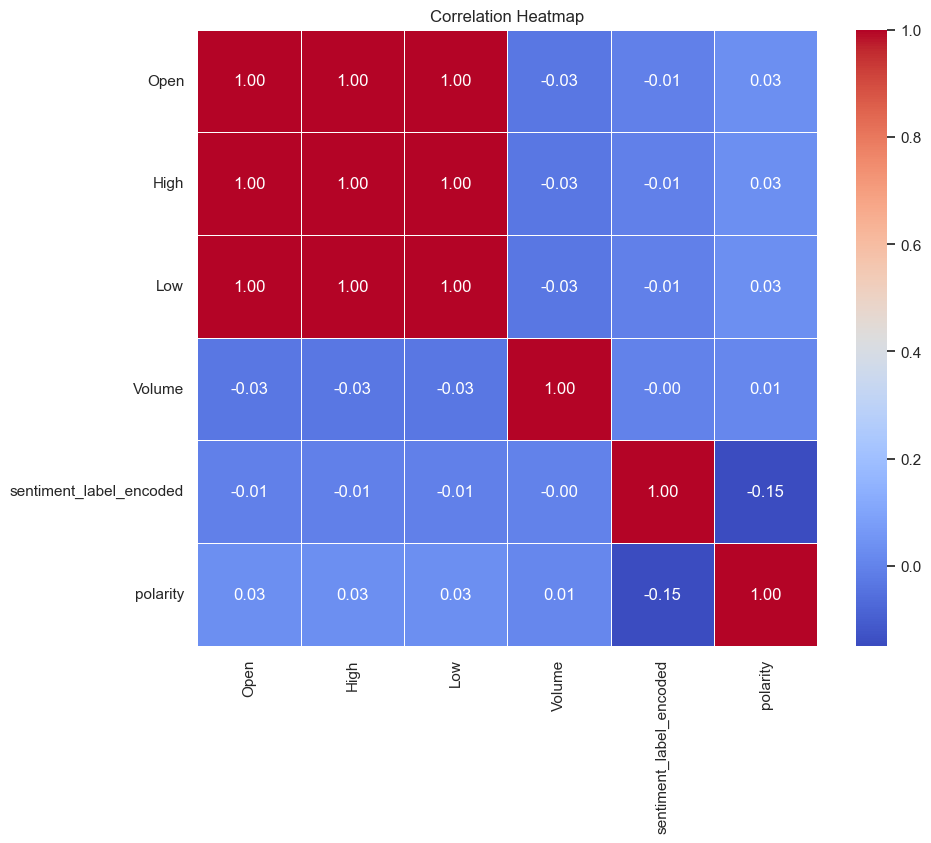

In [29]:
features = final_data[['Open', 'High', 'Low', 'Volume', 'sentiment_label_encoded', 'polarity']]

# Calculate the correlation matrix
correlation_matrix = features.corr()

# Create a colorful correlation heatmap
plt.figure(figsize=(10, 8))
sns.set(style="white")  # Set the background style
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation Heatmap")

# Save the plot as an image
plt.savefig(BLD / "Result" / "Heatmap.png")

plt.show()


#### Step 3: Data is split into Train and Test data

In [30]:
# Specify feature columns (X) and target column (y)
X = final_data[['Volume', 'sentiment_label_encoded', 'polarity']]
y = final_data['Price_Direction']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1234)

#### Step 4: Logistic Regression is employed initially with penalty = None

In [34]:


# Create and train a Logistic Regression model
model = LogisticRegression(random_state=42, fit_intercept=True,penalty=None)
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Extract and interpret the coefficients
coefficients = model.coef_[0]
intercept = model.intercept_[0]

# Create a DataFrame to display the coefficients
coefficients_df = pd.DataFrame({'Feature': X.columns, 'Coefficient': coefficients})
coefficients_df['Magnitude'] = coefficients_df['Coefficient'].abs()

# Sort the coefficients by magnitude
coefficients_df = coefficients_df.sort_values(by='Magnitude', ascending=False)

# Display the coefficients
print("Coefficients:")
print(coefficients_df)

# Intercept term
print(f"Intercept: {intercept}")




Coefficients:
                   Feature  Coefficient  Magnitude
2                 polarity     0.975986   0.975986
1  sentiment_label_encoded     0.057390   0.057390
0                   Volume    -0.003258   0.003258
Intercept: -0.09162261523083415


#### Step 5: Model is evaluated using Accuracy score and Classification Report

In [35]:
# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
classification_report_str = classification_report(y_test, y_pred, zero_division=1)

print(f"Accuracy: {accuracy}")
print("Classification Report:")
print(classification_report_str)

Accuracy: 0.5279731993299832
Classification Report:
                precision    recall  f1-score   support

direction_down       0.51      0.23      0.32      1418
  direction_up       0.53      0.80      0.64      1567

      accuracy                           0.53      2985
     macro avg       0.52      0.51      0.48      2985
  weighted avg       0.52      0.53      0.49      2985



#### Step 6: Systematic hyperparameter tuning using GridSearchCV method

In [36]:
from sklearn.model_selection import GridSearchCV
param_grid = {"penalty": ["l2"],"C": [1, 10, 100]}
grid = GridSearchCV(LogisticRegression(),param_grid,cv=7 )
grid.fit(X_train, y_train)


GridSearchCV(cv=7, estimator=LogisticRegression(),
             param_grid={'C': [1, 10, 100], 'penalty': ['l2']})

In [37]:
grid.best_params_

{'C': 1, 'penalty': 'l2'}

In [38]:
grid.best_estimator_.score(X_test, y_test)

0.5319932998324958

#### Step 7: Set-up the parametes, based on the tuning suggestions and evaluate the performance of the model

In [43]:


# Create and train a Logistic Regression model
model = LogisticRegression(random_state=10, fit_intercept=True, class_weight='balanced', penalty='l2', C = 1)
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
classification_report_str = classification_report(y_test, y_pred, zero_division=1)

print(f"Accuracy: {accuracy}")
print("Classification Report:")
print(classification_report_str)


Accuracy: 0.5061976549413736
Classification Report:
                precision    recall  f1-score   support

direction_down       0.48      0.44      0.46      1418
  direction_up       0.53      0.56      0.55      1567

      accuracy                           0.51      2985
     macro avg       0.50      0.50      0.50      2985
  weighted avg       0.50      0.51      0.50      2985



#### Step 8: graphical Representation:  Sentiment analysis features (Sentiment_Label, Polarity) Vs Target (Price_Direction)

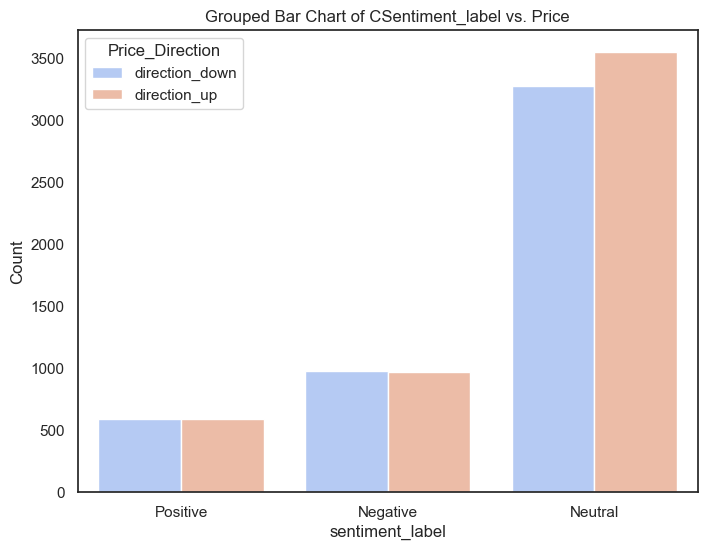

In [44]:
import matplotlib.pyplot as plt
import seaborn as sns

# Define the categorical feature variable
categorical_feature = 'sentiment_label'

# Define the target variable
target = 'Price_Direction'

# Create a grouped bar chart to visualize the relationship between the categorical variable and the target
plt.figure(figsize=(8, 6))
sns.countplot(x=categorical_feature, hue=target, data=final_data, palette='coolwarm')

# Add labels and a legend
plt.xlabel(categorical_feature)
plt.ylabel('Count')
plt.title('Grouped Bar Chart of CSentiment_label vs. Price')
plt.legend(title=target)
# Save the plot as an image
plt.savefig(BLD / "Result" / "sentiment_vs_Price.png")
# Show the plot
plot_show = plt.show()




No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


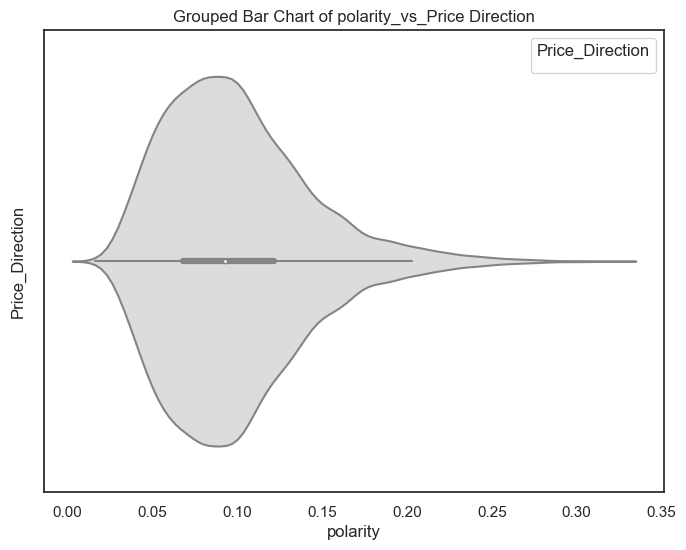

In [45]:
feature = 'polarity'
# Define the target variable
target = 'Price_Direction'

# Create a grouped bar chart to visualize the relationship between the categorical variable and the target
plt.figure(figsize=(8, 6))
sns.violinplot(x=feature, hue=target, data=final_data, palette='coolwarm')

# Add labels and a legend
plt.xlabel(feature)
plt.ylabel(target)
plt.title('Grouped Bar Chart of polarity_vs_Price Direction')
plt.legend(title=target)

# Save the plot as an image
plt.savefig(BLD / "Result" / "polarity_vs_Price.png")
# Show the plot
plot_show = plt.show()